In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
from langchain_core.messages import AIMessage,HumanMessage
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
os.environ["LANGSMITH_API_KEY"] = os.getenv('LANGSMITH_API_KEY')
os.environ["GROQ_API_KEY"] = os.getenv('GROQ_API_KEY')

In [10]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OpenAIEmbeddings

In [15]:
from langchain.tools import tool

In [3]:
from langchain.chat_models import init_chat_model
llm = init_chat_model('groq:qwen/qwen3-32b')

# ChatGroq(model='qwen/qwen3-32b')

In [4]:
wiki_api_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool = WikipediaQueryRun(api_wrapper=wiki_api_wrapper)

In [11]:
embeddings = OpenAIEmbeddings()

C:\Users\Admin\AppData\Local\Temp\ipykernel_5568\2497576997.py:1: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-openai package and should be used instead. To use it run `pip install -U `langchain-openai` and import as `from `langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings()


In [ ]:
# Vector Retrieval Tool
def retriever_tool(file):
    docs = TextLoader(file,encoding='utf-8').load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=500).split_documents(docs)
    vectorestore = Chroma.from_documents(chunks,embedding=embeddings)
    vs_retriever = vectorestore.as_retriever()
    
    @tool("rag_retriever",description="Retrieval Tool")
    def query_tool(query: str) -> str:
      resutls =  vs_retriever.invoke(query)
      return "\n\n".join(doc.page_content for doc in resutls)
    return query_tool



In [ ]:
tool = retriever_tool("../data/Notes.txt")

In [36]:
tool

StructuredTool(name='rag_retriever', description='Retrieval Tool', args_schema=<class 'langchain_core.utils.pydantic.rag_retriever'>, func=<function retriever_tool.<locals>.query_tool at 0x00000145C9296660>)

In [31]:
# Agent to Agent Communication
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import MessagesState, END
from langgraph.types import Command

In [32]:
def get_next_node(last_msg:BaseMessage,goto:str):
    if "Final Answer" in last_msg.content:
        return END
    return goto

In [34]:
def system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [38]:
# Research Agent
from langchain.agents import create_agent
research_agent = create_agent(
    llm,
    tools=[wiki_tool,tool],
    system_prompt=system_prompt("You can only do research. Use the tool that you are binded with, you can use both of them" \
    " You are working with a content writer colleague.")    
    )

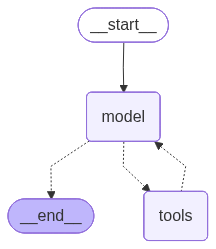

In [39]:
research_agent

In [51]:
# Research Node
from typing import Literal

def research_node(state:MessagesState) -> Command[Literal["blog_generator", END]]:
    print("Research Node")
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1],"blog_generator")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update= {
            "messages": result["messages"]
        },
        goto=goto
    )


In [47]:
# Blog Agent
blog_agent = create_agent(
    llm,
    tools=[wiki_tool],
    system_prompt=system_prompt("You can only write detailed blog. Use the tool that you are binded with" \
    " You are working with a researcher colleague.")    
    )

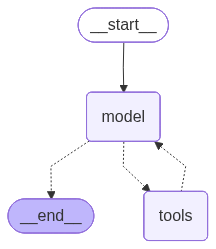

In [43]:
blog_agent

In [ ]:
def blog_node(state:MessagesState) -> Command[Literal["researcher", END]]:
    print("Blog Node")
    result = blog_agent.invoke(state)
    goto = get_next_node(result["messages"][-1],"researcher")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="blog_generator"
    )
    return Command( 
        update= {
            "messages": result["messages"]
        },
        goto=goto
    )


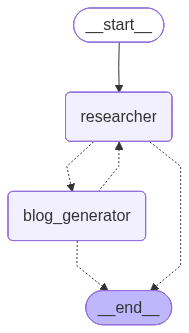

In [50]:
from langgraph.graph import StateGraph, START
workflow = StateGraph(MessagesState)

workflow.add_node("researcher",research_node)
workflow.add_node("blog_generator",blog_node)
workflow.add_edge(START,"researcher")

graph = workflow.compile()
graph

In [54]:
response = graph.invoke({"messages":"Write a detailed blog on Transformers variant"})

In [55]:
response["messages"][-1].content

"Here’s the expanded and finalized blog incorporating additional insights and recent advancements:\n\n---\n\n### **Advanced Variants and Emerging Trends**  \n#### **1. DeBERTa: Enhanced Contextual Understanding**  \n- **Developer**: Microsoft (2021)  \n- **Innovation**: Introduced an **enhanced mask decoder** and **disentangled attention** mechanism, allowing the model to better infer masked tokens by leveraging both content and position information.  \n- **Impact**: Outperformed BERT and RoBERTa on tasks like question-answering and text classification.  \n\n#### **2. Longformer: Handling Long Documents**  \n- **Developer**: Allen Institute for AI (2020)  \n- **Innovation**: Designed for long-range dependencies with **sliding window attention** and **dilated attention**, enabling efficient processing of documents up to 1 million tokens.  \n- **Use Cases**: Legal document analysis, scientific paper summarization.  \n\n#### **3. Switch Transformers: Sparse Mixture-of-Experts**  \n- **Dev